# Manipulation des images après l'application du Mask-RCNN

**Ce script propose plusieurs manipulations: toutes les opérations ne se suivent pas**

* Nombres d'objets détéctés par classe
* Déplacer les images par classe
* Redimensionner les images par les coordonnées détéctée
* Grouper les images d'un ratio similaire
* Analyse des objets liés aux images contenant des corps

In [2]:
#Import librairies

import cv2
import os, shutil
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter
import json
from PIL import Image
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

**Classes Mask-Rcnn**

In [18]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

class_id = range(0,81)
class_dict = dict(zip(class_id, class_names))
df_class = pd.DataFrame.from_dict(class_dict, orient ='index', columns=['Class'])
df_class.reset_index(inplace=True)
df_class = df_class.rename(columns = {'index':'ID'})
class_dict

{0: 'BG',
 1: 'person',
 2: 'bicycle',
 3: 'car',
 4: 'motorcycle',
 5: 'airplane',
 6: 'bus',
 7: 'train',
 8: 'truck',
 9: 'boat',
 10: 'traffic light',
 11: 'fire hydrant',
 12: 'stop sign',
 13: 'parking meter',
 14: 'bench',
 15: 'bird',
 16: 'cat',
 17: 'dog',
 18: 'horse',
 19: 'sheep',
 20: 'cow',
 21: 'elephant',
 22: 'bear',
 23: 'zebra',
 24: 'giraffe',
 25: 'backpack',
 26: 'umbrella',
 27: 'handbag',
 28: 'tie',
 29: 'suitcase',
 30: 'frisbee',
 31: 'skis',
 32: 'snowboard',
 33: 'sports ball',
 34: 'kite',
 35: 'baseball bat',
 36: 'baseball glove',
 37: 'skateboard',
 38: 'surfboard',
 39: 'tennis racket',
 40: 'bottle',
 41: 'wine glass',
 42: 'cup',
 43: 'fork',
 44: 'knife',
 45: 'spoon',
 46: 'bowl',
 47: 'banana',
 48: 'apple',
 49: 'sandwich',
 50: 'orange',
 51: 'broccoli',
 52: 'carrot',
 53: 'hot dog',
 54: 'pizza',
 55: 'donut',
 56: 'cake',
 57: 'chair',
 58: 'couch',
 59: 'potted plant',
 60: 'bed',
 61: 'dining table',
 62: 'toilet',
 63: 'tv',
 64: 'laptop'

**Objets pour une classe**

In [19]:
folder = ' '

In [20]:
#Folders' images

folder_files = []
for root, dirs, files in os.walk(folder):
    for f in files:
        folder_files.append(f[-6:-4])
        for i, v in enumerate(folder_files):
            if v.startswith('_'):
                folder_files[i] = v.replace(v, v[1])
            if v.endswith('.'):
                folder_files[i] = v.replace(v, v[0])

In [21]:
#Count classes per corpus

a = Counter(folder_files)
df_count = pd.DataFrame.from_dict(a, orient ='index', columns=['Count'])
df_count.reset_index(inplace=True)
df_count = df_count.rename(columns = {'index':'ID'})
df_count = df_count.astype('int64')
df_count.sort_values(by='Count', ascending=False)

,ID,Count
0,1,6228
23,6,1212
8,0,1143
18,3,1088
6,5,986
...,...,...
76,49,8
77,13,8
69,69,7
17,23,6


In [22]:
#Merge

df = pd.merge(df_class, df_count, on=['ID','ID'])

In [23]:
#Add percentage of files with a class for all the images

df['%'] = round((df.Count / len(folder_files))*100, 2)

In [ ]:
#Plot

df.sort_values('Count',ascending=False, inplace=True)
ax = df.set_index("Class").plot(kind = "bar", figsize=(18,6))
ax.set_xlabel("Countries", fontsize=16)
plt.title("Items collected by Country", fontsize=16)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize=10)

In [ ]:
#Dataframe to figure
#From https://stackoverflow.com/questions/19726663/how-to-save-the-pandas-dataframe-series-data-as-a-figure

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='black', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

In [ ]:
#Display and save figure

fig,ax = render_mpl_table(df.sort_values(by='Count', ascending=False), header_columns=0, col_width=2.0)
fig.savefig("table_class_esoterism.svg")

**Déplacer les images par 'class id'**

* Choisir dossier (e.g. with mask, cropped, etc.)
* Choisir une classe (e.g. person=1, wine glass= 41, etc.)
* Sauvegarder dans un nouveau dossier

In [ ]:
def Request(path_in: str, path_out: str, classID:int, class_dict):
    
    if not os.path.isdir(path_out):
        os.mkdir(path_out)

    c = classID
    ext = ['.jpg', '.jpeg', '.json', '.png']
    len_folder = []
    for root, dirs, files in os.walk(path_in):
        for f in tqdm(files):
            ff, fj = os.path.splitext(f)
            if fj.endswith(tuple(ext)):
                if ff.endswith('_' + str(c)):
                    filepath = os.path.join(root, f)
                    path_save = os.path.join(path_out + '/' +f)
                    path_from = os.path.join(root + '/' + f)
                    os.stat(path_out).st_mode
                    len_folder.append(f)
                    shutil.copy(path_from, path_save)
            else:
                continue
                
    for key,value in class_dict.items():
        if key == int(c):
            v = value

    print(f'Done !\n{len(len_folder)} images for class : ' + str(v))

In [ ]:
Request(path_in= input('Enter path in : '), path_out=input('Enter path out : '), classID=input('Enter Class ID : '), class_dict=class_dict)

**Redimensionner les images par les coordonnées détéctées**

* Choisir un dossier avec les fichier JSON
* Choisir la sortie
* Les images doivent avoir les mêmes dimensions qu'a l'origine
* Garder ou non la position dans l'espace, découper le détail ou non


In [ ]:
#Paramètres

path_out =  ' '
path_images = ' '
path_json = ' '
space = 'False'

In [ ]:
from PIL import Image

if not os.path.isdir(path_out):
        os.mkdir(path_out)
        
ext = ['.jpg', '.jpeg', '.png']
for root, dirs, files in os.walk(path_json):
        for f in tqdm(files):
            try:
                #import json
                data = json.load(open(root+'/' + os.path.splitext(f)[0] +'.json', 'r'))
                
                if f.endswith(tuple(ext)):
                    #import image
                    rename = (data['image_id'] + os.path.splitext(f)[1])
                    image = Image.open(path_images +'/' + rename)
                    image_arr = np.array(image)
                    path_o = os.path.join(path_out+'/'+f)
                    
                    if space == 'False':
                        #crop
                        crop = image_arr[data['x1']:data['y1'], data['x2']:data['y2']]
                        image_crop = Image.fromarray(crop)
                        image_crop.save(path_o)
                        
                    else:
                        img =np.zeros(image_arr.shape, dtype = "uint8")
                        img[data['x1']:data['y1'], data['x2']:data['y2']] = 255
                        res = image*img
                        space_crop = Image.fromarray(cv2.bitwise_not(res))
                        space_crop.save(path_o)
                else:
                    continue
                        
            except:
                continue
                
print('Done !')

In [ ]:
#Copier les images, dans un dossier, contenant des personnes
#Cela marche avec d'autres catégories et coprus

path_out =  ' '
path_images = ' '
path_json = ' '

if not os.path.isdir(path_out):
        os.mkdir(path_out)
        
ext = ['.jpg', '.jpeg', '.png']
for root, dirs, files in os.walk(path_json):
        for f in tqdm(files):
            data = json.load(open(root+'/' + os.path.splitext(f)[0] +'.json', 'r'))
            path_save = os.path.join(path_out + '/' + data['image_id'] +'.jpg')
            path_from = os.path.join(path_images + '/' + data['image_id'] +'.jpg')
            os.stat(path_out).st_mode
            len_folder.append(f)
            shutil.copy(path_from, path_save)
                
print('Done !')

**Grouper les images d'un ratio similaire**

* Calcul du rapport de l'image découpée
* Choix des seuils pour les différents rapports : vertical, horizontal et carré

In [ ]:
# First take a cropped image and look at ratio threshold

from PIL import Image
data = json.load(open('2020-05-05_12-13-46_UTC_1_1.json'))
img = Image.open('2020-05-05_12-13-46_UTC_1_1.jpg')
imgCrop = Image.open('2020-05-05_12-13-46_UTC_1_1.jpg')
imgBase = Image.open('2020-05-05_12-13-46_UTC_1.jpg')
img_arr = np.array(img)
r = round((data['y1'] - data['x1']) / (data['y2'] - data['x2']), 3)
print(f'Ratio is {r} and image shape is {img_arr.shape}')

In [26]:
#Parmaters

path_out =  ' '
path_images = ' '
path_json = ' '
treshold_up = 0.7
treshold_down = 0.2

In [27]:
if not os.path.isdir(path_out):
        os.mkdir(path_out)
        
len_folder = []
ext = ['.jpg', '.jpeg', '.png']
for root, dirs, files in os.walk(path_json):
        for f in tqdm(files):
            data = json.load(open(root+'/' + os.path.splitext(f)[0] +'.json', 'r'))
            ratio = round((data['y1'] - data['x1']) / (data['y2'] - data['x2']), 3)
            if ratio < float(treshold_up) and ratio > float(treshold_down):
                if f.endswith(tuple(ext)):
                    filepath = os.path.join(root, f)
                    path_save = os.path.join(path_out + '/' +f)
                    path_from = os.path.join(path_images + '/' + data['image_id']+'.jpg')
                    os.stat(path_out).st_mode
                    len_folder.append(f)
                    shutil.copy(path_from, path_save)
            else:
                continue
print(f'Done !\n{len(len_folder)} images copy')

100%|██████████| 12184/12184 [00:21<00:00, 578.20it/s]

Done !
384 images copy


In [ ]:
#copy Json for the images with ratio

path_out =  '../M_venus/#venus_01_json'
path_json = '../M_venus/#venus_01'

if not os.path.isdir(path_out):
        os.mkdir(path_out)
        
len_folder = []
ext = ['.json']
for root, dirs, files in os.walk(path_json):
        for f in tqdm(files):
            try:
                if f.endswith(tuple(ext)):
                        #copy json to new folder
                        path_save = os.path.join(path_out + '/' +f)
                        path_from = os.path.join(path_json + '/' + f)
                        os.stat(path_out).st_mode
                        len_folder.append(f)
                        shutil.copy(path_from, path_save)
                else:
                    continue
                        
            except:
                continue
                
print(f'Done !\n{len(len_folder)} json copy')

**Calcul du pourcentage de l'image découpée**

In [ ]:
#Compute percentage of detail regarding to the image
#Parmaters

from PIL import Image
#path_images = ' '
path_json = ' '


per = []
name = []
for root, dirs, files in os.walk(path_json):
        for f in tqdm(files):
            try:

                data = json.load(open(root+'/' + os.path.splitext(f)[0] +'.json', 'r'))
                cropS = (data['y2']-data['x2'])*(abs(data['x1']-data['y1']))
                img = (root+'/' + os.path.splitext(f)[0] +'.jpg')
                imgBase = Image.open(img)
                img_arr = np.array(imgBase)
                imgS = img_arr.shape[0]*img_arr.shape[1]
                p = round((cropS/imgS)*100,0)
                per.append(p)
                name.append(os.path.splitext(f)[0])
                P = dict(zip(name, per))
                        
            except:
                continue
                
print('Done !')

 54%|█████▍    | 6610/12184 [02:06<01:47, 52.03it/s]

In [218]:
#Or get from an othe corpus

path_ = ' '
fpath = []
for root, dirs, files in os.walk(path_):
        for f in tqdm(files):
            fpath.append(' '+'/' + os.path.splitext(f)[0] +'.json')

100%|██████████| 164/164 [00:00<00:00, 148374.86it/s]


In [219]:
#And then compute percentage of detail regarding to the image
#Parmaters

from PIL import Image


per = []
name = []
for f in tqdm(fpath):
        data = json.load(open(f, 'r'))
        cropS = (data['y2']-data['x2'])*(abs(data['x1']-data['y1']))
        img = (f[:-5] +'.jpg')
        #img = (root+'/' + os.path.splitext(f)[0] +'.jpg')
        imgBase = Image.open(img)
        img_arr = np.array(imgBase)
        imgS = img_arr.shape[0]*img_arr.shape[1]
        p = round((cropS/imgS)*100,0)
        per.append(p)
        name.append(os.path.splitext(f)[0])
        P = dict(zip(name, per)) 
        
print('Done !')

100%|██████████| 164/164 [00:10<00:00, 15.13it/s]


Done !


In [ ]:
df_pimg = pd.DataFrame.from_dict(P,orient ='index', columns=['percent'])
df_pimg = df_pimg.astype('int64')
df_pimg.sort_values(by='percent', ascending=False)

In [213]:
#Threshold
#Because under 10% the crop is not relevant

df_pimg10 = df_pimg[df_pimg['percent'] > 10]

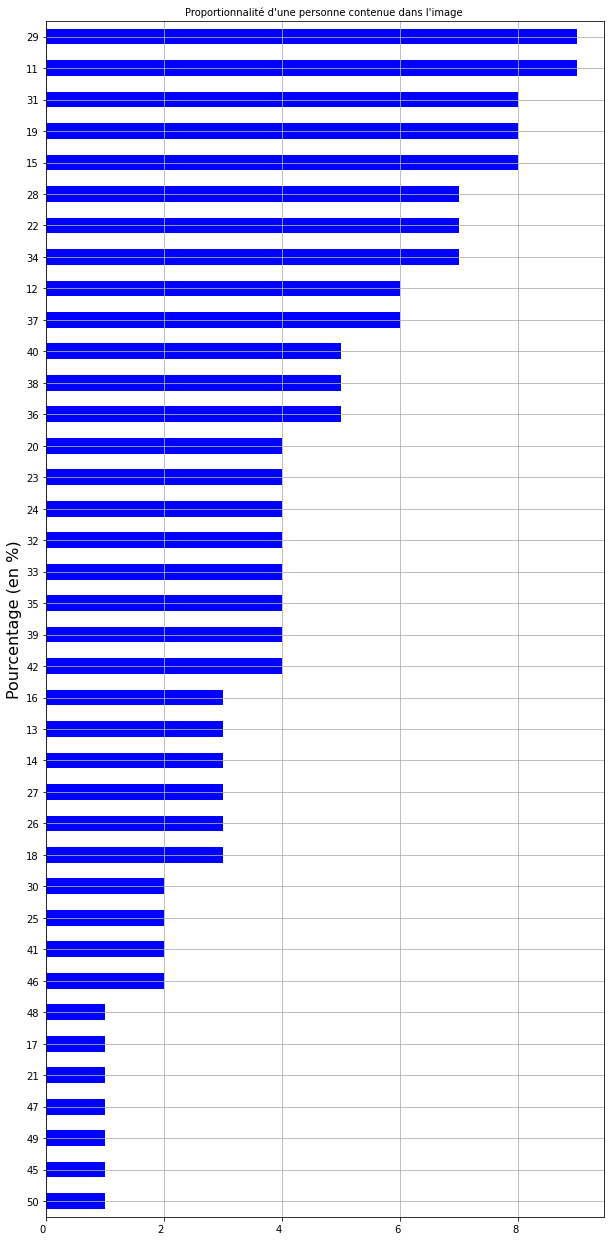

In [214]:
#Plot

prob = df_pimg10.percent.value_counts(ascending=True)
ax = prob.plot(kind = "barh", figsize=(10,22), color='blue')
ax.set_ylabel("Pourcentage (en %)", fontsize=16)
plt.title("Proportionnalité d'une personne contenue dans l'image ", fontsize=10)
plt.xticks(
    rotation=0, 
    horizontalalignment='right',
    fontsize=10)
plt.grid(True)
#plt.savefig('proportion_artSquare.svg')

Déplacer les images selon les résultats

In [221]:
#df_pimg_save = df_pimg[(df_pimg['percent'] == 11) | (df_pimg['percent'] == 29) | (df_pimg['percent'] == 31)]
df_pimg_save = df_pimg[(df_pimg['percent'] > 11) & (df_pimg['percent'] < 22)]
df_pimg_save.index[0][-27:] #un peu de bricolage pour récupérer le nom

'1/2020-04-08_12-34-38_UTC_1'

In [222]:
l_img = df_pimg_save.index.tolist()
print(l_img[0][-27:], 'Nombres d\'images :', len(l_img), l_img[0]) #la façon dont le nom est récupérer servira ensuite

1/2020-04-08_12-34-38_UTC_1 Nombres d'images : 28 ../M_venus/corpus_esoterism_mask_C1/2020-04-08_12-34-38_UTC_1


In [137]:
#Copier les images, dans un dossier, contenant des personnes
#Cela marche avec d'autres catégories et coprus

path_out =  ' '

if not os.path.isdir(path_out):
        os.mkdir(path_out)

for f in tqdm(l_img):
    path_from = os.path.join(f + '.jpg')
    path_save = os.path.join(path_out + '/' + f[-25:] +'.jpg')
    os.stat(path_out).st_mode
    shutil.copy(path_from, path_save)
                
print('Done !')

100%|██████████| 28/28 [00:00<00:00, 733.43it/s]

Done !


In [170]:
#Voir les images

from PIL import Image

def display_images(
    images, name, columns=5, width=20, height=8, max_images=350, 
    label_wrap_length=50, label_font_size=8):

    if not images:
        print("No images to display.")
        return 

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):
        ima = os.path.join(image + '.jpg')
        img = Image.open(ima)
        img = img.convert('RGB')
        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.axis('off')
        plt.imshow(img)
    
    plt.savefig(name)

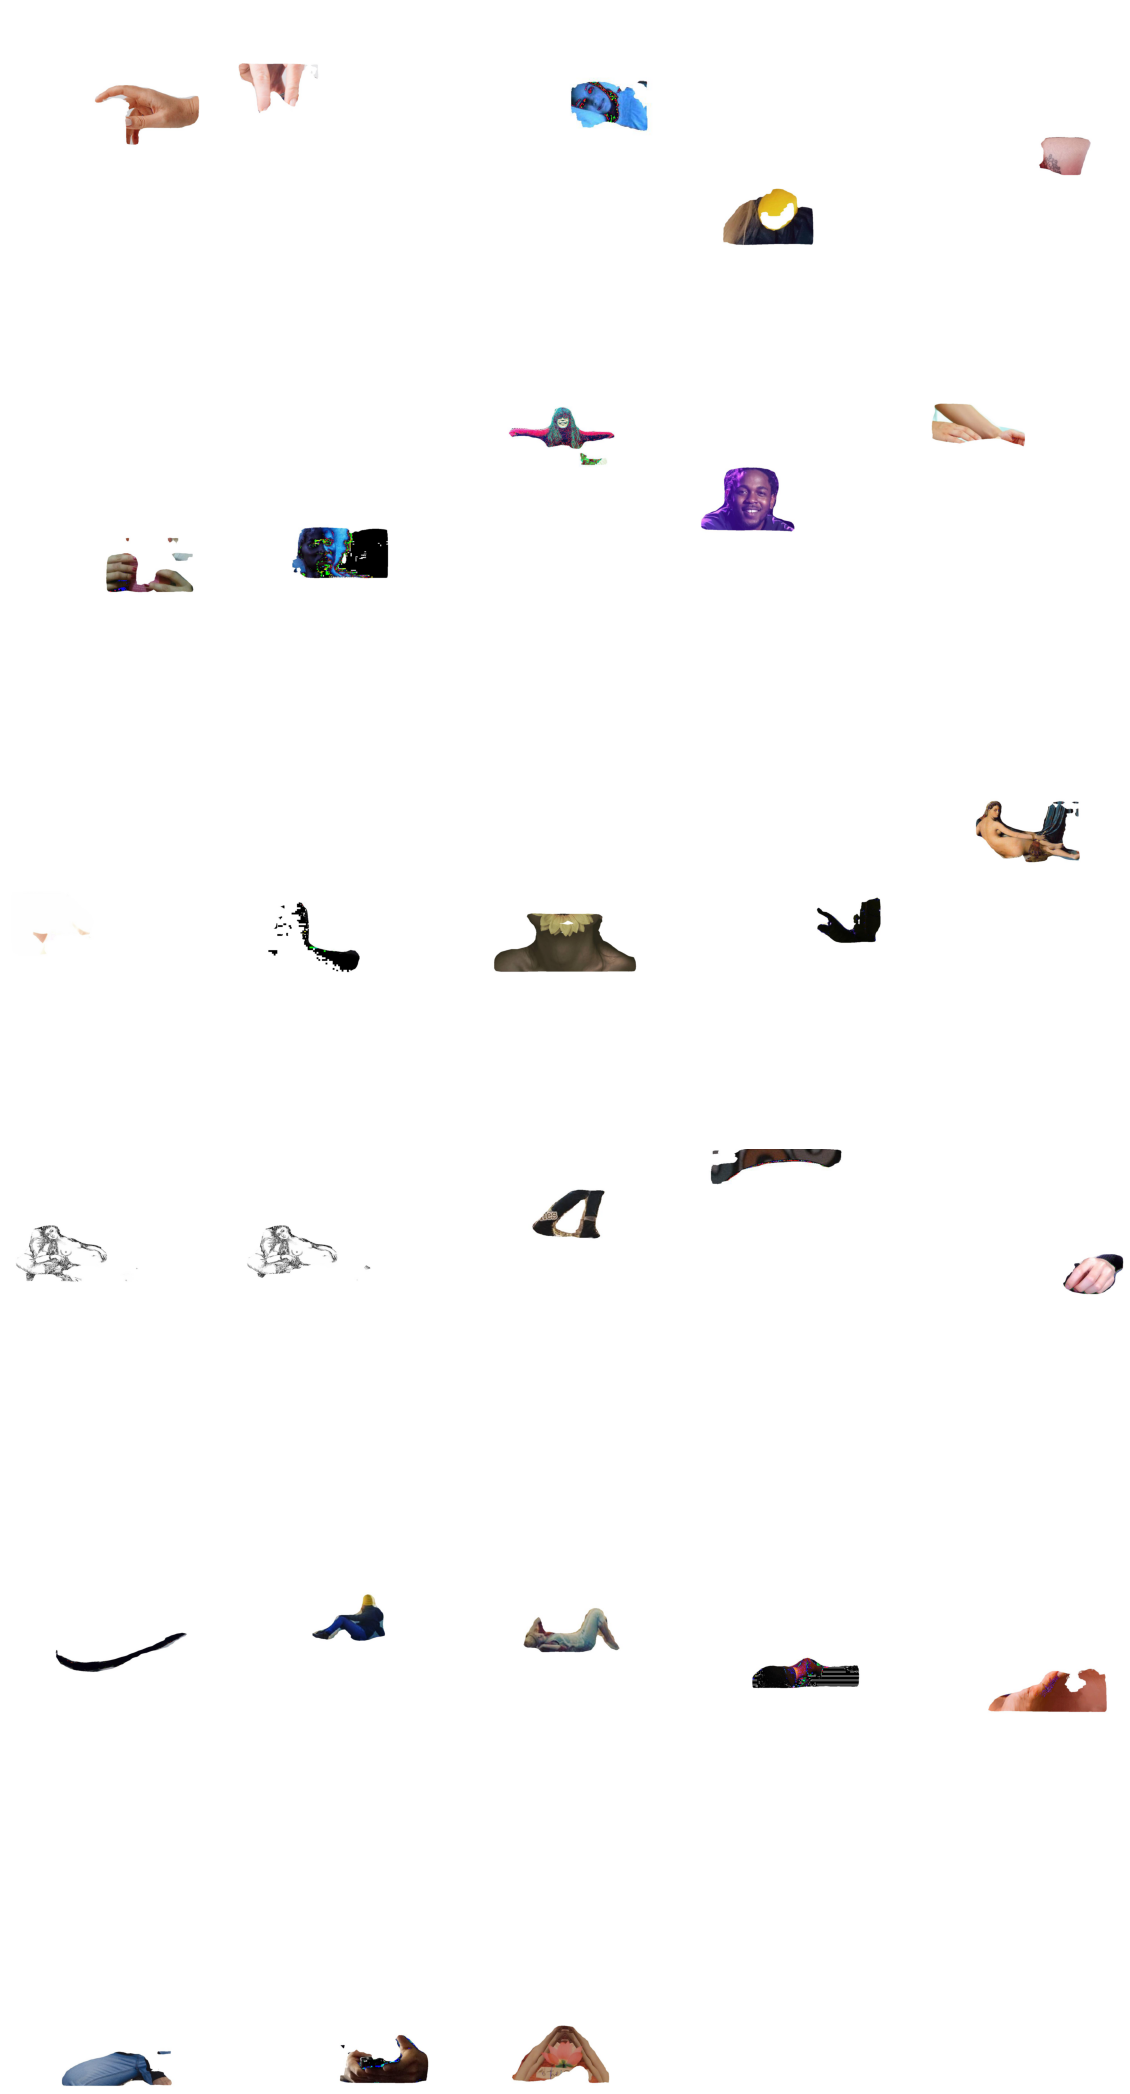

In [223]:
display_images(l_img, name=(' ' + '.svg'))

### **Analyse des objets liés aux images contenant des corps**

Pour les deux corpus, 'art' et 'ésotérisme'.

In [ ]:
#Get all files with a person

pE =  ' '
pers_filesE = []
for root, dirs, files in os.walk(pE):
    for f in tqdm(files):
        if f.endswith('1.json'):
            data = json.load(open(root+'/' + os.path.splitext(f)[0] +'.json', 'r'))
            pers_filesE.append(data['image_id'])

print(f'Number of files containing at least one body : {len(pers_filesE)}')

In [ ]:
#Get all files with a person
 ../M_venus/corpus_art_mask'
pers_filesA = []
for r, d, fi in os.walk(pA):
    for fl in tqdm(fi):
        if fl.endswith('1.json'):
            data = json.load(open(r+'/' + os.path.splitext(fl)[0] +'.json', 'r'))
            pers_filesA.append(data['image_id'])

print(f'Number of files containing at least one body : {len(pers_filesA)}')

In [ ]:
#Get all objects linked to a body in an image

obj_filesE = []
ext = ['1.json', '1.jpeg']
for root, dirs, files in os.walk(pE):
    for f in tqdm(files):
        if not f.endswith(tuple(ext)):
            if f.startswith(tuple(pers_filesE)):
                obj_filesE.append(f)
                
print(len(obj_filesE))

In [ ]:
#Get all objects linked to a body in an image

obj_filesA = []
ext = ['1.json', '1.jpeg']
for r, d, fi in os.walk(pA):
    for fl in tqdm(fi):
        if not fl.endswith(tuple(ext)):
            if fl.startswith(tuple(pers_filesA)):
                obj_filesA.append(fl)
                
print(len(obj_filesA))

In [ ]:
ff=[]
for f in obj_filesE:
    ff.append(f[-6:-4])
    for i, v in enumerate(ff):
        if v.startswith('_'):
            ff[i] = v.replace(v, v[1])
        if v.endswith('.'):
            ff[i] = v.replace(v, v[0])

In [ ]:
fs=[]
for f in obj_filesA:
    fs.append(f[-6:-4])
    for i, v in enumerate(fs):
        if v.startswith('_'):
            fs[i] = v.replace(v, v[1])
        if v.endswith('.'):
            fs[i] = v.replace(v, v[0])

In [ ]:
#Count classes per corpus

a = Counter(ff)
df_count = pd.DataFrame.from_dict(a, orient ='index', columns=['Count Esoterisme'])
df_count.reset_index(inplace=True)
df_count = df_count.rename(columns = {'index':'ID'})
df_count = df_count.astype('int64')
df_count.sort_values(by='Count Esoterisme', ascending=False)

In [ ]:
#Count classes per corpus

aa = Counter(fs)
df_countA = pd.DataFrame.from_dict(aa, orient ='index', columns=['Count Art'])
df_countA.reset_index(inplace=True)
df_countA = df_countA.rename(columns = {'index':'ID'})
df_countA = df_countA.astype('int64')
df_countA.sort_values(by='Count Art', ascending=False)

In [ ]:
#Merge

dff = pd.merge(df_class, df_count, on=['ID','ID'])
df = pd.merge(dff, df_countA, on=['ID','ID'])

#Add percentage of files with a class for all the images

df['Esoterisme (%)'] = round((df_count['Count Esoterisme'] / len(obj_filesE))*100, 2)
df['Art (%)'] = round((df_countA['Count Art'] / len(obj_filesA))*100, 2)

df = df[['Class', 'Esoterisme (%)', 'Art (%)']]

In [ ]:
df.sort_values(['Esoterisme (%)', 'Art (%)'],ascending=False, inplace=True)
ax = df.set_index("Class").plot(kind = "bar", figsize=(22,6))
ax.set_xlabel("Classes", fontsize=16)
plt.title("Pourcentage des objets contenus dans les images contenant des personnes ", fontsize=16)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize=15)